In [1]:
import torch
import torchvision
import torchvision.transforms as transforms



https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

파이토치 튜토리얼 참고


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)


validation_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)



testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


Show image


In [3]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5 #unnormalize
  npimg = img.numpy()

  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()



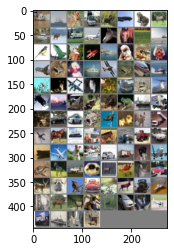

  cat  ship  deer truck  deer plane  frog horse


In [5]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

#show image
imshow(torchvision.utils.make_grid(images))

#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8) ))

Define CNN

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()

    # Conv2D(in_channels, out_channels, kernel_size)
    self.conv1 = nn.Conv2d(3, 6, 5)
    self.pool = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(6, 16, 5)

    self.fc1 = nn.Linear(16*5*5, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)



  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))

    x = x.view(-1, 16*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))

    x = self.fc3(x)

    return x


net = Net()


In [7]:
import torch.nn as nn
import torch.nn.functional as F

# LeNet

class LeNet(nn.Module):

  def __init__(self):
    super().__init__()
    # 채널, 출력, filter size, stride
    self.conv1 = nn.Conv2d(3, 20,5, 1)

    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    
    self.fc1 = nn.Linear(5*5*50, 500)

    self.dropout1 = nn.Dropout(0.5)

    self.fc2 = nn.Linear(500,10)


  def forward(self, x):

    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)

    #flatten
    x = x.view(-1, 5*5*50)

    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)

    return x


net = LeNet()


In [8]:
class LeNet_2(nn.Module):
  
  def __init__(self):
    super().__init__()
    # 32px 이었다가, conv를 거치면서 절반으로 감소
    self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
    self.fc1 = nn.Linear(4*4*64, 500)
    self.dropout1 = nn.Dropout(0.5)
    self.fc2 = nn.Linear(500, 10)
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*64)
    x = F.relu(self.fc1(x))
    x = self.dropout1(x)
    x = self.fc2(x)
    return x

  
net = LeNet_2()

Loss and optimizer

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



TPU 사용 코드 추가

In [1]:
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [2]:
!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.6-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 133.2MB 93kB/s 
     |████████████████████████████████| 61kB 2.8MB/s 
  Found existing installation: google-api-python-client 1.7.12
    Uninstalling google-api-python-client-1.7.12:
      Successfully uninstalled google-api-python-client-1.7.12


In [13]:
import torch_xla
import torch_xla.core.xla_model as xm


device = xm.xla_device()




Training Network

Training

In [11]:
epochs = 50
running_loss_history = []
running_correct_history = []
validation_running_loss_history = [] 
validation_running_correct_history = []

for e in range(epochs):
  
  running_loss = 0.0
  running_correct = 0.0
  validation_running_loss = 0.0
  validation_running_correct = 0.0
  
  for i, data in enumerate(trainloader, 0):
    # data : list of [inputs, labels]
    inputs, labels = data
    outputs = net(inputs)
    
    

    # TPU CODE

    # net = net.to(device)
    # input, labels = data
    # input = input.to(device)
    # labels = labels.to(device)
    # outputs = net(input)


    loss = criterion(outputs, labels)


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(outputs, 1)
    
    running_correct += torch.sum(preds == labels.data)
    running_loss += loss.item()
    

  else:    
    # 훈련팔 필요가 없으므로 메모리 절약
    with torch.no_grad():
      
      for i, data in  enumerate(validation_loader, 0):
        
        val_input, val_label = data
        val_outputs = net(val_input)

        
        # TPU CODE
        # val_input, val_label = data
        # net = net.to(device)
        # val_input = val_input.to(device)
        # val_label = val_label.to(device)
        # val_outputs = net(val_outputs)




        val_loss = criterion(val_outputs, val_label)
        

        _, val_preds = torch.max(val_outputs, 1)
        validation_running_loss += val_loss.item()
        validation_running_correct += torch.sum(val_preds == val_label.data) 
    
    
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = running_correct.float() / len(trainloader)
    running_loss_history.append(epoch_loss)
    running_correct_history.append(epoch_acc)
    
    val_epoch_loss = validation_running_loss / len(validation_loader)
    val_epoch_acc = validation_running_correct.float() / len(validation_loader)
    validation_running_loss_history.append(val_epoch_loss)
    validation_running_correct_history.append(val_epoch_acc)
    
    print("===================================================")
    print("epoch: ", e + 1)
    print("training loss: {:.5f}, acc: {:5f}".format(epoch_loss, epoch_acc))
    print("validation loss: {:.5f}, acc: {:5f}".format(val_epoch_loss, val_epoch_acc))

epoch:  1
training loss: 1.28307, acc: 54.004002
validation loss: 1.28509, acc: 53.509998
epoch:  2
training loss: 1.25535, acc: 55.009998
validation loss: 1.25705, acc: 54.709999
epoch:  3
training loss: 1.22743, acc: 56.198002
validation loss: 1.23837, acc: 55.480000
epoch:  4
training loss: 1.19812, acc: 57.265999
validation loss: 1.21238, acc: 57.189999
epoch:  5
training loss: 1.17136, acc: 58.279999
validation loss: 1.18640, acc: 57.910000
epoch:  6
training loss: 1.14197, acc: 59.473999
validation loss: 1.16003, acc: 59.080002
epoch:  7
training loss: 1.11928, acc: 60.382000
validation loss: 1.14059, acc: 59.349998
epoch:  8
training loss: 1.09614, acc: 61.195999
validation loss: 1.13205, acc: 59.740002
epoch:  9
training loss: 1.07375, acc: 62.046001
validation loss: 1.11637, acc: 60.330002
epoch:  10
training loss: 1.05470, acc: 62.764000
validation loss: 1.08600, acc: 62.000000
epoch:  11
training loss: 1.03220, acc: 63.680000
validation loss: 1.06901, acc: 62.099998
epoch:  